In [302]:
import numpy as np
import matplotlib.pyplot as plt

def get_wave(periods: float, freq:float, xshift: float, yshift: float, ystretch: float, res: int = 1_000):
    '''
    Creates a trigonometric wave function. Given the parameters 
        periods  = 1
        freq     = 1
        xshift   = 0
        yshift   = 0
        ystretch = 1
    one would get a vanilla sine function.
    
    
    Parameters
    ----------
    periods: float
        the amount of periods the wave function should have
        
    freq: float
        the amount of periods within 2*np.pi, freq has to be strictly positive

    xshift: float
        the shift of the vanilla wave function across the x-axis
        
    yshift: float
        the shift of the vanilla wave function across the y-axis
        
    ystretch: float
        the stretch factor across y-axis of a vanilla sine-wave with [-1,1] range, applying
        some factor y_s gives [-y_s, y_s] range
        
    res: float, optional
        determines at what resolution the timeseries is being built 

    '''
    if freq <= 0:
        raise Exception("freq must be strictly positive")
    
    # create arguments for the sine function where
    #   xshift  - shifts the points along the x-axis
    #   periods - determines how often a periods is being produced
    #   res     - determines how many points are being produced over the
    #             given parameters
    points = np.linspace(0 + xshift, periods * 2* np.pi + xshift, res)
    
    # compute the sine values stretching them with `ystretch` and shift them with `yshift`
    y = np.sin(points) * ystretch + yshift 
    
    # computing the arguments range, such that the are scaled correctly
    x = (np.arange(0,res)/res)*2*np.pi*periods/freq
    return np.asarray((x,y))

def get_rect(periods: float, freq:float, xshift: float, yshift: float, ystretch: float, saturation_factor: float, res: float = 1000):
    '''
    Creates a trigonometric wave function. Contrary to the `get_wave` function it will "saturate"
    the wave function, such that it hard-clips it at some factor `sat_fac` 0 <= sat_fac <= 1. Creates a trigonometric wave function. Given the parameters 
        periods = 1
        xshift = 0
        yshift = 0
        ystretch = 1
    one would get a vanilla sine function.
    
    
    Parameters
    ----------
    periods: float
        gives the amount of periods the wave function should have
        
    freq: float
        the amount of periods within 2*np.pi

    xshift: float
        the shift of the vanilla wave function across the x-axis
        
    yshift: float
        the shift of the vanilla wave function across the y-axis
        
    ystretch: float
        the stretch factor across y-axis of a vanilla sine-wave with [-1,1] range, applying
        some factor y_s gives [-y_s, y_s] range
        
    saturation_factor: float
        the factor how much a sine function is being hard clipped creating a rectangle-similar function, the factor is supposed to be in the range [0,1] where 0 is no saturation at all and 1 clipping completely creating a straight line
        
    res: float, optional
        determines at what resolution the timeseries is being built 
    '''
    if saturation_factor > 1 or saturation_factor < 0:
        raise Exception("saturation_factor is supposed to be in the range [0,1]")
    data = get_wave(periods, freq, xshift, yshift, ystretch, res)
    
    # determine max and min points of the wave
    max_pt = np.max(data[1])
    min_pt = np.min(data[1])
    
    # determine wave vertical length
    v_length = np.abs(max_pt - min_pt)
    
    # determine hard-clip points relative to max and min points
    sat_max_pt = (min_pt + max_pt)/2 + v_length*saturation_factor
    sat_min_pt = (min_pt + max_pt)/2 - v_length*saturation_factor
    
    # mask out the points outside of the clipping range
    mask_top = data[1] <= sat_max_pt
    mask_bottom = data[1] >= sat_min_pt
    clipped = np.where(mask_top, data[1], sat_max_pt)
    clipped = np.where(mask_bottom, clipped, sat_min_pt)

    # reassign wave and output
    data[1] = clipped
    return data

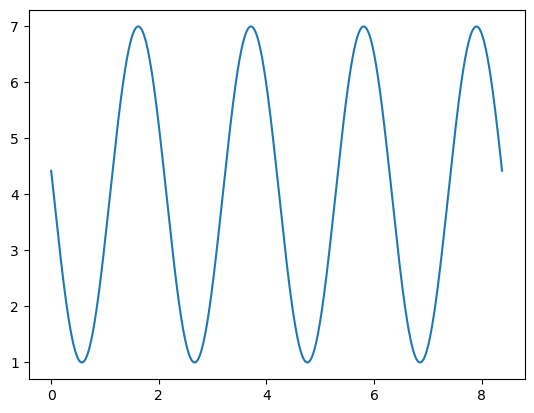

In [328]:
# Testing wave functions and see a plot

x,y = get_wave(periods=4, 
               freq=3,
               xshift=3, 
               yshift=4, 
               ystretch=3,
               res=10000)
plt.plot(x, y)

In [352]:
def create_dataset(n: int, seed: int=1337, res: int=10_000):
    """
    Creates a dataset of vanilla sine waves and clipped sine waves which we will refer to rectangle functions,
    though they are not precisely rectangle functions 
    
    Parameters
    ----------
    n: int
        number of samples generated for each class, which are
        0 - sine waves
        1 - rectangle waves
        
    seed: int
        random seed
    
    res: int
        number of samples created
    """
    np.random.seed(seed)
    waves = []
    rects = []
    for _ in range(n):
        periods  = np.random.randint(1_000)/100
        xshift   = np.random.randint(1_000)/100
        yshift   = np.random.randint(1_000)/100
        freq     = np.random.randint(1, 1_000)/800
        ystretch = np.random.randint(1_000)/100
        wave     = get_wave(periods=periods, 
                            xshift=xshift, 
                            yshift=yshift, 
                            freq=freq, 
                            ystretch=ystretch,
                            res=res)
        waves.append(wave)

    for _ in range(n):
        periods  = np.random.randint(1_000)/100
        xshift   = np.random.randint(1_000)/100
        yshift   = np.random.randint(1_000)/100
        freq     = np.random.randint(1, 1_000)/800
        ystretch = np.random.randint(1_000)/100
        sat      = np.random.randint(400)/1_000
        rect   = get_rect(periods=periods,
                          xshift=xshift, 
                          yshift=yshift, 
                          freq=freq, 
                          ystretch=ystretch,
                          saturation_factor=sat,
                          res=res)
        rects.append(rect)
    return waves, rects
    

data = create_dataset(100)

0.205
1.17
1.03375
0.39875
0.80625
0.91625
0.53
1.22875
1.17
0.1425
0.92625
0.26875
0.18875
0.96875
1.1075
0.0775
1.08375
1.0075
1.05125
0.69
0.62125
0.06875
1.18875
0.88125
0.4525
0.55875
0.39
0.7425
0.9475
0.30875
0.26125
0.39375
1.17125
0.52125
1.04875
0.92875
0.315
0.395
0.37375
1.06875
0.16625
1.0325
0.73875
0.15375
0.47
0.33125
0.80375
1.0275
1.21125
1.07625
0.7675
0.41875
0.15
1.05875
0.5575
0.09625
0.4
0.39875
0.78625
0.8275
0.2125
0.39875
0.81
1.02375
0.62
0.455
0.445
1.2375
0.86625
1.07
0.01125
0.24125
0.00125
0.68
0.945
0.13
0.65875
0.8125
1.13875
0.85875
0.4025
0.09625
0.5875
0.025
0.04125
0.62875
0.17125
0.67375
0.55125
0.625
0.60375
1.18625
0.715
1.02125
0.81875
0.135
0.26375
0.08375
0.66625
1.02


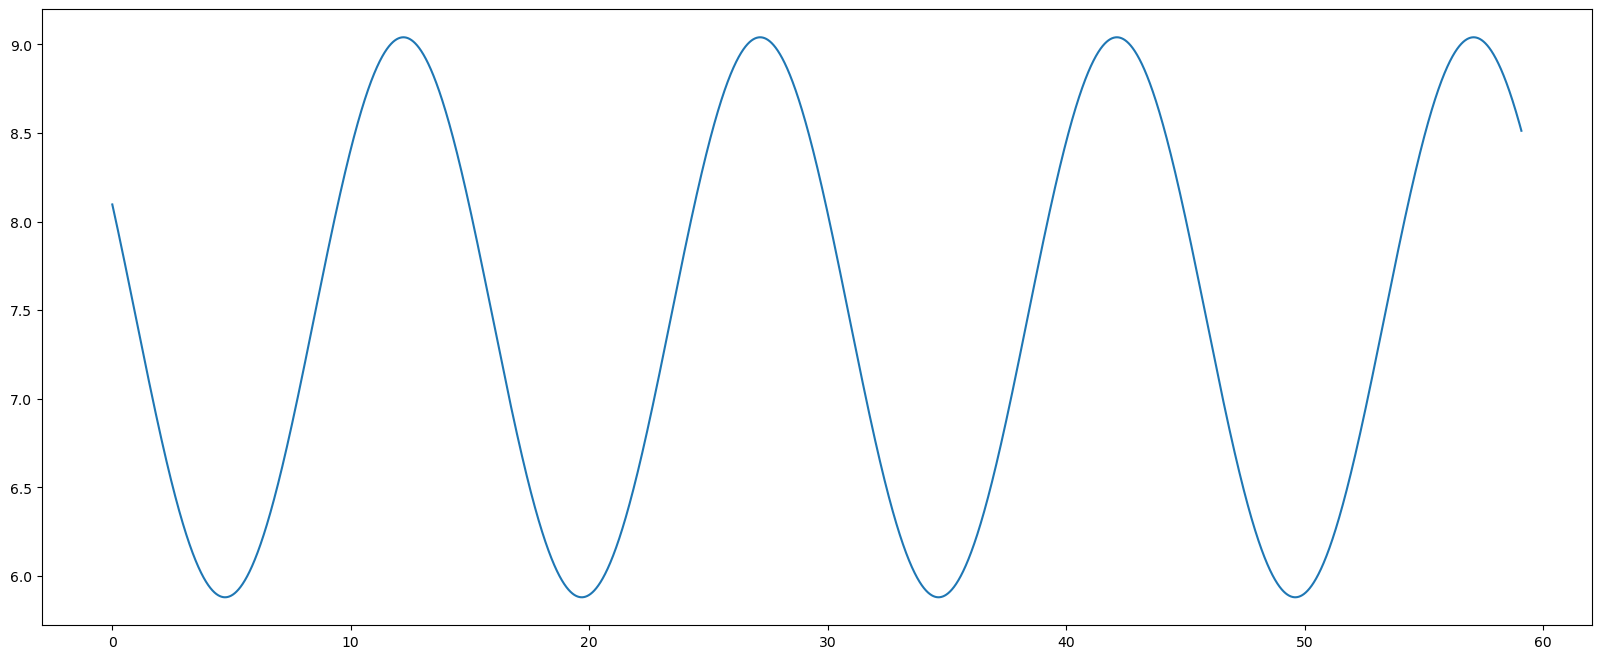

In [359]:
sample = 33
x=data[0][sample][0]
y=data[0][sample][1]

plt.figure(figsize=(20,8))
plt.plot(x,y)

In [318]:
np.fft.rfft(data[1][sample][1])

array([ 3.67218162e+04+0.00000000e+00j,  6.30026170e+02-1.70420087e+02j,
        6.56043198e+02-3.55152969e+02j, ...,
       -4.07051624e+00+2.04959125e-03j, -4.07073885e+00+9.93506952e-04j,
       -4.07079702e+00+0.00000000e+00j])

In [11]:
from scipy.fft import fft, ifft, rfft 

X = rfft(data[1][sample][1])
N = len(X)

# Generate the exponential form representation

formula = "DFT Coefficients:\n\n"
for k in range(N):
    if k == 0:
        formula += f"DC Component: {X[k].real:.2f}\n"
    elif k == N - 1:
        formula += f"Nyquist Frequency Component: {X[k].real:.2f}\n"
    else:
        formula += f"Frequency Component at {k} Hz: {X[k].real:.2f} * exp(-i2pi * {k} * t / N) + {X[k].imag:.2f} * exp(i2pi * {k} * t / N)\n"

print(formula)

DFT Coefficients:

DC Component: 131.54
Frequency Component at 1 Hz: -1.41 * exp(-i2pi * 1 * t / N) + 0.11 * exp(i2pi * 1 * t / N)
Frequency Component at 2 Hz: -1.44 * exp(-i2pi * 2 * t / N) + 0.24 * exp(i2pi * 2 * t / N)
Frequency Component at 3 Hz: -1.50 * exp(-i2pi * 3 * t / N) + 0.45 * exp(i2pi * 3 * t / N)
Frequency Component at 4 Hz: -1.59 * exp(-i2pi * 4 * t / N) + 0.88 * exp(i2pi * 4 * t / N)
Frequency Component at 5 Hz: -1.79 * exp(-i2pi * 5 * t / N) + 2.31 * exp(i2pi * 5 * t / N)
Frequency Component at 6 Hz: -0.15 * exp(-i2pi * 6 * t / N) + -19.08 * exp(i2pi * 6 * t / N)
Frequency Component at 7 Hz: -1.69 * exp(-i2pi * 7 * t / N) + -2.61 * exp(i2pi * 7 * t / N)
Frequency Component at 8 Hz: -2.04 * exp(-i2pi * 8 * t / N) + -1.69 * exp(i2pi * 8 * t / N)
Frequency Component at 9 Hz: -2.54 * exp(-i2pi * 9 * t / N) + -1.43 * exp(i2pi * 9 * t / N)
Frequency Component at 10 Hz: -3.55 * exp(-i2pi * 10 * t / N) + -1.43 * exp(i2pi * 10 * t / N)
Frequency Component at 11 Hz: -7.24 * exp

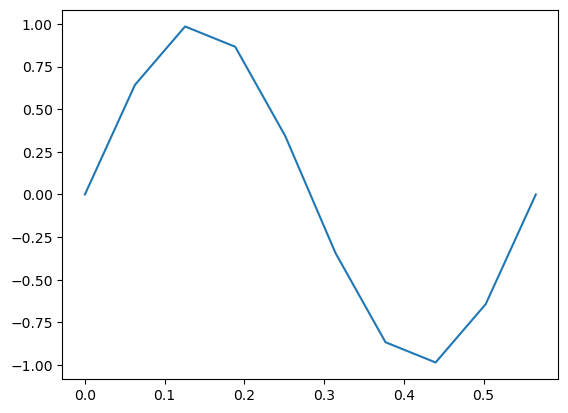

In [364]:
x,y = get_wave(1,10,0,0,1,10)
print(x)
plt.plot(x,y)